# Searching Higgs boson with shallow neural network

This work aims to replicate work presented in the article *Baldi, P., P. Sadowski, and D. Whiteson. “[Searching for Exotic Particles in High-energy Physics with Deep Learning.](https://arxiv.org/pdf/1402.4735.pdf)” Nature Communications 5 (July 2, 2014).* 

The abstract of the article states that "*Collisions at high-energy particle colliders are a traditionally fruitful source of exotic particle discoveries. Finding these rare particles requires solving difficult signal-versus-background classification problems, hence machine learning approaches are often used. [...] Using benchmark datasets, we show that deep learning methods need no manually constructed inputs and yet improve the classification metric by as much as 8% over the best current approaches. This demonstrates that deep learning approaches can improve the power of collider searches for exotic particles.*"

In this notebook, **shallow** neural network is trained and evaluated. See the other notebook to compare the model behavior to **deep** neural network. 

The dataset used in the original article, and used in this work as well, can be downloaded from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/HIGGS). Dataset description can be found from the article. The work desctibed in the article uses Pylearn2 to train neural networks, but Tensorflow and Keras are used in this work. See also [code in GitHub](https://github.com/uci-igb/higgs-susy) used in the original article. 

### Load packages and the dataset 
First, we load necessary packages and tweak some settings. 

In [45]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_curve,roc_auc_score
import matplotlib.pyplot as plt

#show all datacolumns
pd.set_option('display.max_columns', None)

#### Load the dataset

We need only the class label and low level features, that is, columns 1-22. High level features which have been derived from low level features, are in columns 23-29 and are left out. As in the original article, we will use 2.6 million datapoints for training and testing, and 100000 datapoints for validation. 

In total, dataset contains 11 million datapoints, created simulating 8 TeV collisions of protons in the  Large  Hadron Collider. The dataset has 53 % positive examples. 

In [3]:
nrows = 2700000
dataset = pd.read_csv('HIGGS.csv.gz', 
                      compression='gzip', 
                      usecols = list(range(0,22)), 
                      nrows = nrows,
                      header = None)

Print the firs few roads to make sure loading was done correctly. 

In [4]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,1.374992,-0.653674,0.930349,1.107436,1.138904,-1.578198,-1.046985,0.000000,0.657930,-0.010455,-0.045767,3.101961
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000


Rename columns to be more descriptive. More details can be found from the original article.

In [5]:
dataset.columns = ['class label', 'lepton pT', 'lepton eta', 'lepton phi', 
                   'missing energy magnitude', 'missing energy phi',
                   'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 
                   'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 
                   'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 
                   'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag']

#### Summarize dataset

Print summary of the dataset. 

In [6]:
dataset.describe()

,class label,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag
count,2.700000e+06,2.700000e+06,2.700000e+06,2.700000e+06,2.700000e+06,2.700000e+06,2.700000e+06,2.700000e+06,2.700000e+06,2.700000e+06,2.700000e+06,2.700000e+06,2.700000e+06,2.700000e+06,2.700000e+06,2.700000e+06,2.700000e+06,2.700000e+06,2.700000e+06,2.700000e+06,2.700000e+06,2.700000e+06
mean,5.296293e-01,9.909409e-01,9.253686e-05,-1.395469e-04,9.984468e-01,-8.749087e-04,9.906035e-01,-8.740648e-04,1.702342e-04,1.001145e+00,9.926631e-01,9.102140e-04,3.110029e-04,9.992781e-01,9.921080e-01,7.703819e-04,-1.328006e-04,1.000472e+00,9.857632e-01,-1.505805e-04,-1.715120e-04,9.990510e-01
std,4.991214e-01,5.649760e-01,1.008743e+00,1.006115e+00,5.997951e-01,1.006298e+00,4.743528e-01,1.009375e+00,1.006139e+00,1.027864e+00,5.003603e-01,1.009635e+00,1.006305e+00,1.049302e+00,4.871230e-01,1.008181e+00,1.006190e+00,1.193898e+00,5.056508e-01,1.007874e+00,1.006411e+00,1.399764e+00
min,0.000000e+00,2.746966e-01,-2.434976e+00,-1.742508e+00,6.259872e-04,-1.743944e+00,1.378689e-01,-2.969725e+00,-1.741237e+00,0.000000e+00,1.889811e-01,-2.913090e+00,-1.742372e+00,0.000000e+00,2.636076e-01,-2.729663e+00,-1.742069e+00,0.000000e+00,3.653542e-01,-2.497265e+00,-1.742691e+00,0.000000e+00
25%,0.000000e+00,5.902043e-01,-7.383225e-01,-8.719308e-01,5.766937e-01,-8.717021e-01,6.791759e-01,-6.882352e-01,-8.675418e-01,0.000000e+00,6.565868e-01,-6.944718e-01,-8.696243e-01,0.000000e+00,6.506770e-01,-6.979879e-01,-8.716891e-01,0.000000e+00,6.170371e-01,-7.141902e-01,-8.720338e-01,0.000000e+00
50%,1.000000e+00,8.528224e-01,9.198132e-04,4.165800e-04,8.914954e-01,-1.651530e-03,8.944529e-01,-2.005896e-03,5.813991e-05,1.086538e+00,8.900118e-01,1.031646e-03,1.009147e-03,0.000000e+00,8.972494e-01,1.083142e-03,-7.519117e-04,0.000000e+00,8.675030e-01,3.721330e-04,-1.373983e-03,0.000000e+00
75%,1.000000e+00,1.235677e+00,7.382142e-01,8.704391e-01,1.292881e+00,8.706938e-01,1.170649e+00,6.862039e-01,8.688670e-01,2.173076e+00,1.201654e+00,6.965352e-01,8.704274e-01,2.214872e+00,1.221622e+00,7.001541e-01,8.708400e-01,2.548224e+00,1.220930e+00,7.141017e-01,8.710505e-01,3.101961e+00
max,1.000000e+00,9.690881e+00,2.434868e+00,1.743236e+00,1.539682e+01,1.743257e+00,8.848616e+00,2.969674e+00,1.741454e+00,2.173076e+00,1.164708e+01,2.913210e+00,1.743175e+00,2.214872e+00,8.864838e+00,2.730009e+00,1.742884e+00,2.548224e+00,1.162123e+01,2.498009e+00,1.743372e+00,3.101961e+00


The original article describes the **signal and background processes** in the following way: 

"*The  signal  process  is  the  fusion  of  two  gluons  into  a heavy electrically-neutral Higgs boson (gg→H$^0$), which decays to a heavy electrically-charged Higgs bosons (H$^±$) and a W boson.  The H± boson subsequently decays to a second W boson and the light Higgs boson, h$^0$ [...].  The  light  Higgs  boson  decays  predominantly to a pair of bottom quarks, giving the process:*

*$gg$ → H$^0$ → W$^∓$H$^±$ → W$^∓$W$^±$h$^0$ → W$^∓$W$^±$ $b \bar b$,*

*[...].  The background process, which mimics W$^∓$W$^±$ $b \bar b$ without the Higgs boson intermediate state, is the production of a pair of top quarks, each of which decay to W$b$, also giving W$^∓$W$^±$ $b \bar b$.*"

The **low level features** in the dataset are described in the article as follows: 

"*We  focus  on  the  semi-leptonic  decay  mode,  in  which one W boson decays to a lepton and neutrino (lν) and the other decays to a pair of jets (jj), giving decay products lνb jjb.   We  consider  events  which  satisfy  the  requirements:*
- *Exactly one electron or muon, with pT > 20 GeV and |η| < 2.5;*
- *at least four jets, each with pT > 20 GeV and |η| < 2.5;*
- *b-tags  on  at  least  two  of  the  jets,  indicating  that they are likely due to b-quarks rather than gluons or lighter quarks.*"

### Get training and validation sets from the dataset 

#### Split input and output variables
Split dataset into input (X) and output (y) variables. Trivially, class label is the output variable.

In [7]:
X = dataset.iloc[:,1:23]
y = dataset.iloc[:,0] 
X.head()

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag
0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,1.374992,-0.653674,0.930349,1.107436,1.138904,-1.578198,-1.046985,0.000000,0.657930,-0.010455,-0.045767,3.101961
1,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000
2,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000
3,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000
4,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000


#### Standardize and scale

Data needs to be standardized: zero mean and standard deviation one. But, for features always greater than zero, scaling is done so that values are between [0,2]. 

In [8]:
standardizedColumns = ['lepton eta', 'lepton phi', 'missing energy phi',
                        'jet 1 eta', 'jet 1 phi', 'jet 2 eta', 'jet 2 phi', 
                        'jet 3 eta', 'jet 3 phi', 'jet 4 eta', 'jet 4 phi']
X_standardized = StandardScaler().fit_transform(X[standardizedColumns]) 
X_df_standardized = pd.DataFrame(X_standardized)
X_df_standardized.columns = standardizedColumns

In [9]:
scaledColums = ['lepton pT', 'missing energy magnitude', 
             'jet 1 pt', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 b-tag', 
             'jet 3 pt', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 b-tag']
X_scaled = MinMaxScaler(feature_range=(0, 2)).fit_transform(X[scaledColums]) 
X_df_scaled = pd.DataFrame(X_scaled)
X_df_scaled.columns = scaledColums

Combine to a single training set again. 

In [10]:
X_combined = X_df_standardized.merge(X_df_scaled, left_index=True, right_index=True)
X_combined.tail()

,lepton eta,lepton phi,missing energy phi,jet 1 eta,jet 1 phi,jet 2 eta,jet 2 phi,jet 3 eta,jet 3 phi,jet 4 eta,jet 4 phi,lepton pT,missing energy magnitude,jet 1 pt,jet 1 b-tag,jet 2 pt,jet 2 b-tag,jet 3 pt,jet 3 b-tag,jet 4 pt,jet 4 b-tag
2699995,1.896150,-1.124590,1.004852,-0.862468,-1.383106,-0.435713,0.437366,-0.313886,-0.489639,-1.562046,1.359155,0.007619,0.082926,0.127734,0.0,0.126210,2.0,0.141130,2.0,0.055879,0.0
2699996,-0.128561,-0.898479,1.149392,1.610716,-0.695467,0.581231,-1.487515,0.125808,0.129599,-0.393635,0.485222,0.038444,0.164935,0.070335,0.0,0.114760,2.0,0.211981,2.0,0.096707,0.0
2699997,-1.340297,-0.397174,0.191072,0.633607,1.185176,0.533126,-0.908593,1.535176,1.076220,0.236019,-0.510668,0.013527,0.088314,0.123864,0.0,0.147439,2.0,0.223620,0.0,0.040093,2.0
2699998,1.044555,-1.643541,-0.860585,-0.046249,1.042469,1.142137,-0.516027,0.038230,0.285072,-0.168876,1.548829,0.171189,0.142040,0.241587,0.0,0.325294,0.0,0.231379,2.0,0.132344,1.0
2699999,-1.381815,-1.026425,-1.615197,-0.279735,0.833643,-1.200585,-1.594478,-0.116159,0.049657,0.176524,-0.657337,0.205279,0.086464,0.188583,1.0,0.104190,0.0,0.231256,2.0,0.035292,0.0


#### Training and validation sets

Separate validation set from the training set. 

In [11]:
X_train = X_combined.iloc[0:2500000,:]
y_train = y.iloc[0:2500000]

,lepton eta,lepton phi,missing energy phi,jet 1 eta,jet 1 phi,jet 2 eta,jet 2 phi,jet 3 eta,jet 3 phi,jet 4 eta,jet 4 phi,lepton pT,missing energy magnitude,jet 1 pt,jet 1 b-tag,jet 2 pt,jet 2 b-tag,jet 3 pt,jet 3 b-tag,jet 4 pt,jet 4 b-tag
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,0.002439,-0.004700,-0.003408,-0.007595,-0.001297,-0.001824,-0.001639,0.001356,-0.003411,0.000126,-0.003656,0.152497,0.129536,0.196055,0.920889,0.140387,0.902149,0.169509,0.782318,0.110241,0.650677
std,1.001148,0.998697,0.998358,0.998563,0.999413,1.000832,1.001348,1.001369,0.999641,0.998300,1.001226,0.120675,0.077871,0.109408,0.945785,0.087659,0.947994,0.113070,0.936660,0.089869,0.905136
min,-2.407204,-1.731780,-1.732133,-2.940296,-1.730782,-2.886191,-1.731765,-2.708276,-1.731221,-2.477606,-1.731420,0.000000,0.000485,0.000694,0.000000,0.000110,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.727187,-0.868147,-0.869070,-0.693731,-0.861316,-0.693556,-0.871101,-0.696699,-0.872811,-0.702677,-0.869617,0.067092,0.074816,0.124180,0.000000,0.081554,0.000000,0.089881,0.000000,0.044720,0.000000
50%,0.004682,-0.007270,-0.006510,-0.015837,-0.003968,-0.004690,-0.004371,0.002116,-0.002269,0.005477,-0.006709,0.122755,0.115859,0.173944,1.000000,0.122298,0.000000,0.147419,0.000000,0.089181,0.000000
75%,0.736552,0.857567,0.859162,0.671867,0.860641,0.692835,0.867422,0.697771,0.864513,0.707020,0.858505,0.204715,0.167750,0.237012,2.000000,0.177107,2.000000,0.222497,2.000000,0.151980,2.000000
max,2.413672,1.732780,1.733167,2.941978,1.730659,2.884507,1.731945,2.707091,1.732295,2.478643,1.732438,1.723043,1.377898,1.495751,2.000000,1.332205,2.000000,1.743262,2.000000,1.205847,2.000000


In [38]:
X_validation = X_combined.iloc[2500001:2600000,:].reset_index(drop=True)
y_validation = y.iloc[2500001:2600000].reset_index(drop=True)
X_validation.head()

,lepton eta,lepton phi,missing energy phi,jet 1 eta,jet 1 phi,jet 2 eta,jet 2 phi,jet 3 eta,jet 3 phi,jet 4 eta,jet 4 phi,lepton pT,missing energy magnitude,jet 1 pt,jet 1 b-tag,jet 2 pt,jet 2 b-tag,jet 3 pt,jet 3 b-tag,jet 4 pt,jet 4 b-tag
0,-0.708842,1.150408,0.438815,0.209801,-1.540690,-0.799388,-0.689706,-0.916095,-1.308356,-2.218969,-0.956735,0.241973,0.177467,0.087014,2.0,0.112211,2.0,0.086941,0.0,0.067253,0.0
1,-0.062905,1.319163,0.352391,0.261796,0.025336,-0.273117,-1.164422,1.103608,-1.275828,0.782214,-1.493225,0.520485,0.033706,0.533253,0.0,0.182733,0.0,0.276544,2.0,0.011677,2.0
2,-0.965672,1.310340,-0.489854,-0.743763,0.031948,-0.015273,1.669642,0.444518,1.586194,-1.811594,0.680410,0.074244,0.205228,0.148810,0.0,0.122980,2.0,0.137128,2.0,0.000951,0.0
3,1.013658,1.719545,-1.289075,-0.116883,0.255100,0.594700,-1.290130,0.433684,0.504499,-0.249855,1.016199,0.077431,0.283672,0.235571,2.0,0.080851,0.0,0.143540,2.0,0.011980,0.0
4,0.979865,-1.728471,-0.292773,-0.279735,1.252948,1.323975,-1.178205,-0.026776,0.200720,-0.149045,0.642365,0.060639,0.118440,0.242113,0.0,0.147241,2.0,0.207040,0.0,0.087192,1.0


### Define the architecture for neural network

Define constants for NN architecture. 

In [12]:
noInputUnits = X.shape[1]
noHiddenUnits = 300
learningRate = 0.05
batchSize = 100
noEpochs = 20
validationSplit = 0.2

#TODO TODO#
#weight initialization
learningRateDecay = 1.0000002
learningRateMin = 1e-6
weightDecay = 1e-5

Define the neural network architecture. We are creating a shallow NN with only one hidden layer, as in the article. 

In [14]:
model = Sequential()
model.add(Dense(noHiddenUnits, input_dim=noInputUnits, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 300)               6600      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 301       
Total params: 6,901
Trainable params: 6,901
Non-trainable params: 0
_________________________________________________________________


Compile the keras NN model.

In [15]:
#optimizer = Adam(lr=learningRate)
optimizer = Adam()
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy'])

### Train the neural network 

Fit the keras NN model on the dataset.

In [16]:
fittedModel = model.fit(X_train, y_train, 
                    validation_split = validationSplit,
                    epochs = noEpochs, 
                    batch_size = batchSize)

Epoch 1/20
20000/20000 [==============================] - 261s 13ms/step - loss: 0.6609 - accuracy: 0.5977 - val_loss: 0.6506 - val_accuracy: 0.6145
Epoch 2/20
20000/20000 [==============================] - 230s 12ms/step - loss: 0.6416 - accuracy: 0.6280 - val_loss: 0.6373 - val_accuracy: 0.6339
Epoch 3/20
20000/20000 [==============================] - 243s 12ms/step - loss: 0.6308 - accuracy: 0.6411 - val_loss: 0.6270 - val_accuracy: 0.6453
Epoch 4/20
20000/20000 [==============================] - 257s 13ms/step - loss: 0.6238 - accuracy: 0.6493 - val_loss: 0.6239 - val_accuracy: 0.6491
Epoch 5/20
20000/20000 [==============================] - 257s 13ms/step - loss: 0.6191 - accuracy: 0.6548 - val_loss: 0.6197 - val_accuracy: 0.6542
Epoch 6/20
20000/20000 [==============================] - 252s 13ms/step - loss: 0.6162 - accuracy: 0.6576 - val_loss: 0.6165 - val_accuracy: 0.6574
Epoch 7/20
20000/20000 [==============================] - 254s 13ms/step - loss: 0.6139 - accuracy: 0.6603

### Evaluate the neural network 

Evaluate the keras NN model using validation set. 

In [40]:
_, accuracy = model.evaluate(X_validation, y_validation)

3125/3125 [==============================] - 12s 4ms/step - loss: 0.6010 - accuracy: 0.6745


Make class predictions with the NN model. 

In [41]:
predictions = model.predict_classes(X_validation)

Summarize the first cases. 

In [43]:
for i in range(20):
    print('Row %s => %d (expected %d)' % (i, predictions[i], 
                                          y_validation[i]))

Row 0 => 1 (expected 1)
Row 1 => 1 (expected 1)
Row 2 => 0 (expected 0)
Row 3 => 1 (expected 1)
Row 4 => 1 (expected 0)
Row 5 => 0 (expected 1)
Row 6 => 0 (expected 1)
Row 7 => 0 (expected 1)
Row 8 => 0 (expected 1)
Row 9 => 1 (expected 1)
Row 10 => 1 (expected 0)
Row 11 => 1 (expected 1)
Row 12 => 1 (expected 0)
Row 13 => 0 (expected 1)
Row 14 => 1 (expected 1)
Row 15 => 0 (expected 0)
Row 16 => 1 (expected 1)
Row 17 => 1 (expected 0)
Row 18 => 1 (expected 1)
Row 19 => 0 (expected 0)


#### Plot accuracy

Plot accuracy behavior during epochs. The training and testing phases should not be too much different, otherwise the model is overfitted. 

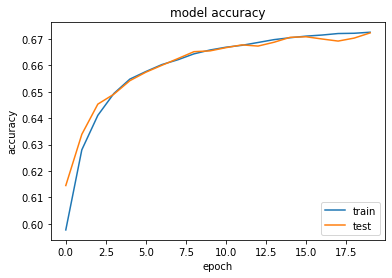

In [29]:
plt.plot(fittedModel.history['accuracy'])
plt.plot(fittedModel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

#### Plot loss 

Plot loss behavior during epochs. 

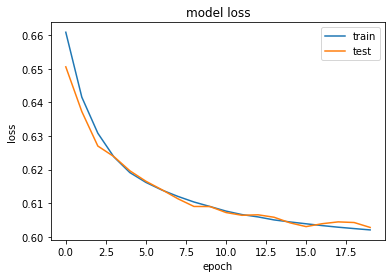

In [30]:
plt.plot(fittedModel.history['loss'])
plt.plot(fittedModel.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#### ROC and AUC

The article used area under the ROC curve (AUC) as primary metric, and we can do that too. ROC curve plots TPR (True Positive Rate) versus FPR (False Positive Rate). First, we create Receiver Operating Characteristic (ROC) curves to illustrate the performance of the classifier. Then, we can get the AUC values, where larger AUC  indicates higher classification accuracy. 

First we need prediction probabilities, so they can be compared to the actual targets. 

In [44]:
y_validationProbablity = model.predict_proba(X_validation)

Instructions for updating:
Please use `model.predict()` instead.


Next, we need to compute the TPR and FPR for various threshold values.

In [47]:
FPR, TPR, thresholds = roc_curve(y_validation, y_validationProbablity)

Now, we can plot the ROC curve, that is TPR vs FPR. 

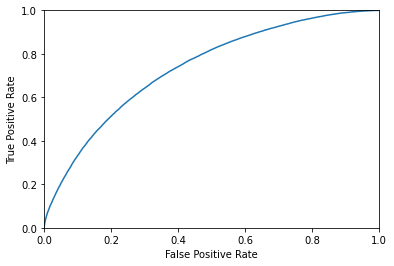

In [48]:
plt.plot(fpr,tpr) 
plt.axis([0,1,0,1]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.show()    

Now, we can calculate area under the curve (AUC). Purely random classifier would have a AUC = 0.5, and perfect classifier would have AUC = 1. 

In [49]:
AUC = roc_auc_score(y_validation, y_validationProbablity) 
AUC

0.7358267619544883

As a single number this doesn't say much, but se can compare it to the AUC obtained with DNN model. 

### Save the model 

Save the trained model for future use.  

In [24]:
model.save('shallow_nn')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: shallow_nn/assets
